# 1. Define the model architecture from Assignment 1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your model from Assignment 1
class CIFAR10CNN(nn.Module):
    def __init__(self, num_conv_layers=3, num_dense_layers=1):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        
        # Define convolutional layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        conv_channels = [64, 128, 256]  # Channels for each conv layer
        
        for i in range(num_conv_layers):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, conv_channels[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]),
                nn.ReLU(),
                nn.Conv2d(conv_channels[i], conv_channels[i]*2, kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]*2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2 + 0.1*i)  # Progressive dropout
            )
            self.conv_layers.append(conv_block)
            in_channels = conv_channels[i]*2
        
        # Calculate input size for dense layers
        self.flatten_size = conv_channels[num_conv_layers-1]*2 * (32 // (2**num_conv_layers))**2
        
        # Define dense layers dynamically
        self.dense_layers = nn.ModuleList()
        dense_sizes = [512, 256]  # Sizes for dense layers
        
        in_features = self.flatten_size
        for i in range(num_dense_layers):
            self.dense_layers.append(nn.Linear(in_features, dense_sizes[i]))
            self.dense_layers.append(nn.ReLU())
            self.dense_layers.append(nn.Dropout(0.4 + 0.1*i))
            in_features = dense_sizes[i]
        
        # Final classification layer
        self.classifier = nn.Linear(in_features, 10)

    def forward(self, x):
        # Pass through conv layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        
        # Final classification
        x = self.classifier(x)
        return x

# 2. Calibrate the model and plot reliability diagrams

Files already downloaded and verified
Before calibration:


/tmp/ipykernel_87760/78197687.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.916
Average confidence: 0.940


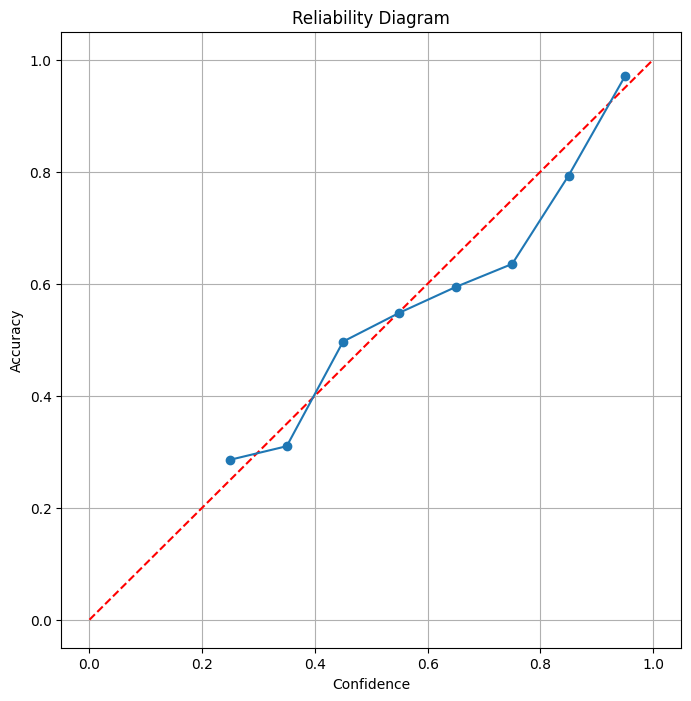


After calibration:
Optimal temperature: 1.500
Accuracy: 0.916
Average confidence: 0.904


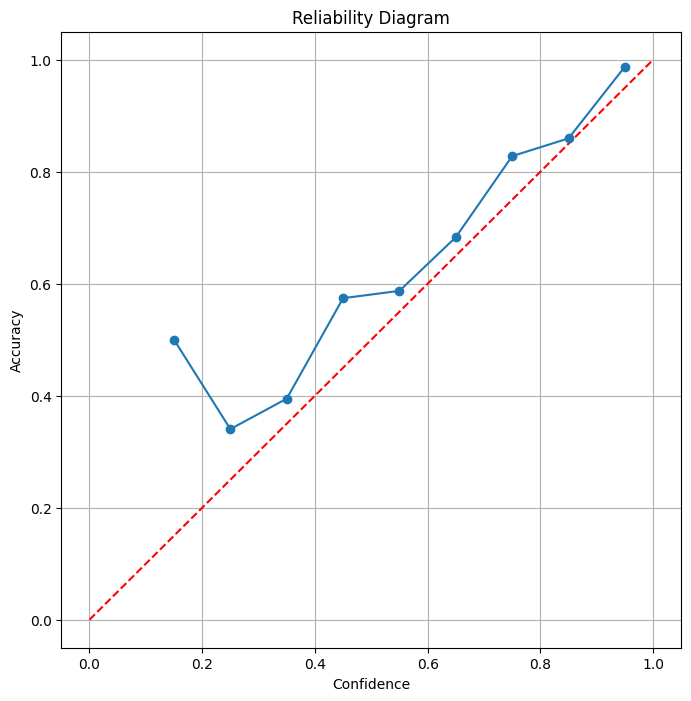

In [5]:
# Temperature scaling model
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return logits / self.temperature

    def get_temperature(self):
        return self.temperature.item()

def get_metrics(model, data_loader, temperature=None):
    model.eval()
    predictions = []
    confidences = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            if temperature is not None:
                outputs = outputs / temperature
                
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, dim=1)
            
            predictions.extend(predicted.cpu().numpy())
            confidences.extend(confidence.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    confidences = np.array(confidences)
    labels_list = np.array(labels_list)
    
    accuracy = (predictions == labels_list).mean()
    avg_confidence = confidences.mean()
    
    return accuracy, avg_confidence, confidences, predictions == labels_list

def plot_reliability_diagram(confidences, accuracies, bins=10):
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'r--')  # Perfect calibration line
    plt.plot(confidences, accuracies, '-o')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.grid(True)
    plt.show()

def calibrate_model():
    # Data loading
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                           shuffle=False, num_workers=2)

    # Load the base model
    base_model = CIFAR10CNN(num_conv_layers=3, num_dense_layers=1).to(device)
    base_model.load_state_dict(torch.load('best_model.pth'))
    base_model.eval()

    # Get metrics before calibration
    print("Before calibration:")
    acc, avg_conf, confs, corrects = get_metrics(base_model, testloader)
    print(f"Accuracy: {acc:.3f}")
    print(f"Average confidence: {avg_conf:.3f}")

    # Plot reliability diagram before calibration
    bin_size = 0.1
    bins = np.arange(0, 1 + bin_size, bin_size)
    bin_accuracies = []
    bin_confidences = []

    for i in range(len(bins)-1):
        mask = (confs >= bins[i]) & (confs < bins[i+1])
        if mask.sum() > 0:
            bin_accuracies.append(corrects[mask].mean())
            bin_confidences.append((bins[i] + bins[i+1])/2)

    plot_reliability_diagram(bin_confidences, bin_accuracies)
    
    # Create calibrated model
    calibrated_model = ModelWithTemperature(base_model).to(device)
    
    # Find optimal temperature
    optimizer = optim.LBFGS([calibrated_model.temperature], lr=0.01, max_iter=50)
    criterion = nn.CrossEntropyLoss()

    def eval():
        optimizer.zero_grad()
        nll = 0
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = calibrated_model(inputs)
            loss = criterion(logits, labels)
            nll += loss.item()
        nll /= len(testloader)
        loss = criterion(logits, labels)
        loss.backward()
        return loss

    optimizer.step(eval)
    
    # Get metrics after calibration
    print("\nAfter calibration:")
    optimal_temperature = calibrated_model.get_temperature()
    print(f"Optimal temperature: {optimal_temperature:.3f}")
    
    acc, avg_conf, confs, corrects = get_metrics(base_model, testloader, temperature=optimal_temperature)
    print(f"Accuracy: {acc:.3f}")
    print(f"Average confidence: {avg_conf:.3f}")

    # Plot reliability diagram after calibration
    bin_accuracies = []
    bin_confidences = []

    for i in range(len(bins)-1):
        mask = (confs >= bins[i]) & (confs < bins[i+1])
        if mask.sum() > 0:
            bin_accuracies.append(corrects[mask].mean())
            bin_confidences.append((bins[i] + bins[i+1])/2)

    plot_reliability_diagram(bin_confidences, bin_accuracies)

if __name__ == '__main__':
    calibrate_model()